# Custom bluesky plan

**Objective**: 
Build a custom plan for an up-down scan using positioner `m2` and `scaler1` channels `I0` and `diode`.

First, a couple lines to make the graphics and also EPICS Channel Access and work here.

In [1]:
try:
    %load_ext dotenv
    %dotenv env.txt
except Exception:
    print(
        "Did not load file with environment variables."
        "  No problem.  Continuing ..."
    )

Did not load file with environment variables.  No problem.  Continuing ...


Start the instrument package.

In [2]:
from instrument.collection import *

I Mon-12:39:32 - ############################################################ startup
I Mon-12:39:32 - logging started
I Mon-12:39:32 - logging level = 10
I Mon-12:39:32 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/collection.py
I Mon-12:39:32 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/mpl/notebook.py
I Mon-12:39:32 - #### Bluesky Framework ####
I Mon-12:39:32 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/check_python.py
I Mon-12:39:32 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/check_bluesky.py


Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


I Mon-12:39:33 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/initialize.py
I Mon-12:39:34 - using databroker catalog 'training'
I Mon-12:39:34 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/framework/metadata.py
I Mon-12:39:34 - #### Devices ####
I Mon-12:39:34 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/area_detector.py
I Mon-12:39:34 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/calculation_records.py
I Mon-12:39:36 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/ioc_stats.py
I Mon-12:39:36 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/motors.py
I Mon-12:39:36 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_training/bluesky/instrument/devices/noisy_detector.py
I Mon-12:39:36 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_train

## Select scaler channels
The scaler channels are selected by calling its `.select_channels()` method:

In [3]:
scaler1.select_channels(["I0", "diode"])

## Count time
The count time is in the `.preset_time` attribute.  The way to set the scaler with this time is to use ophyd's staging process.  Add `preset_time` to the `.stage_sigs` dictionary with the desired count time as the value.

In [4]:
scaler1.stage_sigs["preset_time"] = 1
scaler1.stage_sigs

OrderedDict([('preset_time', 1)])

# Construct the plan
Create a plan that scans up, then scans down (2 scans total).  Add `temperature` just to get some other interesting data.  We'll add a metadata key for the scan direction.

We'll do this in small steps starting with the innermost part.

In [5]:
def up_down_once(lo, hi, num, md={}):
    dets = [scaler1, temperature]
    _md = {}
    _md.update(md)
    _md["direction"] = "up"
    yield from bp.scan(dets, m2, lo, hi, num, md=_md)
    _md["direction"] = "down"
    yield from bp.scan(dets, m2, hi, lo, num, md=_md)

Verify that this code will process through the RunEngine by testing it without running it.  Use the `summarize_plan()` function imported from the `bluesky` package.  This will show the steps of the measurement.

In [6]:
summarize_plan(up_down_once(0, 1, 5))

=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================


Next, build a plan that runs this twice.

In [7]:
def up_down_twice(lo, hi, num, md={}):
    yield from up_down_once(lo, hi, num, md=md)
    yield from up_down_once(lo, hi, num, md=md)

In [8]:
summarize_plan(up_down_twice(0, 1, 5))

=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperatur

Finish the custom plan by setting the count time.  Give a default of 1.0 s.

In [9]:
def customScan(lo=0, hi=1, num=5, ct=1, md={}):
    scaler1.stage_sigs["preset_time"] = ct
    _md = {}
    _md.update(md)
    _md["count_time"] = ct
    _md["example"] = "customPlan"

    scaler1.select_channels(["I0", "diode"])
    yield from up_down_twice(lo, hi, num, md=_md)
    scaler1.select_channels()  # reset for all named channels
    del scaler1.stage_sigs["preset_time"]  # remove our custom staging

In [10]:
summarize_plan(customScan(md=dict(demo="concise custom plan example")))

=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 1.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.75
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.5
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
================================== Close Run ===================================
=================================== Open Run ===================================
m2 -> 0.0
  Read ['scaler1', 'temperature', 'm2']
m2 -> 0.25
  Read ['scaler1', 'temperatur

## Run
Run the `customScan()` plan, using the RunEngine object: `RE()`



Transient Scan ID: 224     Time: 2021-07-26 12:40:48
Persistent Unique Scan ID: '8386e5e0-555d-4bc9-8b04-b03c00dd84ec'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+------------+------------+------------+----------------------+
|   seq_num |       time |         m2 |         I0 |      diode | temperature_readback |
+-----------+------------+------------+------------+------------+----------------------+
|         1 | 12:40:50.6 |    0.00000 |          5 |          4 |             24.89284 |
|         2 | 12:40:52.4 |    0.25000 |          5 |          6 |             25.12834 |
|         3 | 12:40:54.2 |    0.50000 |          4 |          3 |             24.83422 |
|         4 | 12:40:56.0 |    0.75000 |          4 |          6 |             25.38966 |
|         5 | 12:40:57.8 |    1.00000 |          5 |          5 |             25.38966 |
+-----------+------------+------------+------------+------------+----------------------+
generator scan ['8386e5e0'] (scan

('8386e5e0-555d-4bc9-8b04-b03c00dd84ec',
 '9812c5ba-b6e5-4434-9a30-f786c3e722e0',
 '0239c875-5138-42a0-82a1-a9c91b41aed9',
 'e9f61f0e-94a6-4fe3-8777-5be312fe4374')

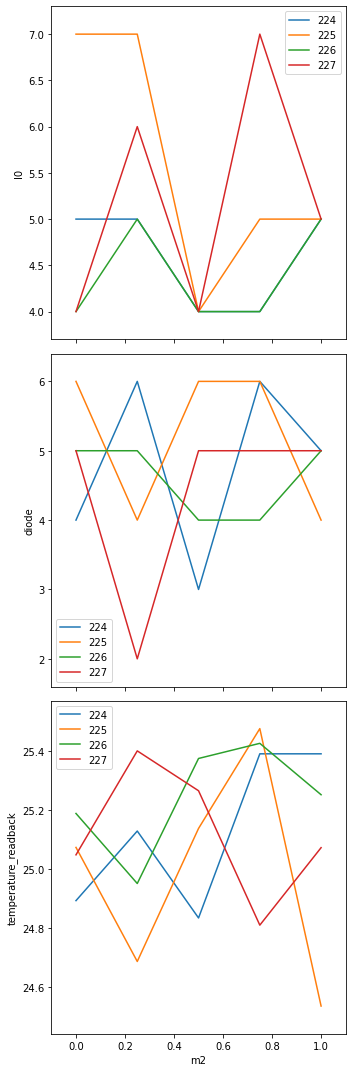

In [11]:
RE(customScan(md=dict(demo="concise custom plan example")))

## Next Steps

Make these additions or improvements to the plans:

1. Let the caller specify how many *up*-*down* iterations.
1. Let the caller specify the counting time. (hint: `scaler1.stage_sigs["preset_time"] = value` **before** calling `bp.scan()`)
1. Wait between *up* and *down* scans for some time (caller-specified). (hint: `yield from bps.sleep(seconds)`)
1. Use `logger` to report at various places.  (hint: `logger.info("text: %s  value: %g", s1, v2, ...)`)
1. Control the `shutter` (hint: `yield from bps.mv(shutter, "open")` or `close`)
1. Change the temperature before *up* scan and then before *down* scan.  (hint: `yield from bps.mv(temperature, value)`)